In [1]:
# Install the surprise package
!pip install -q -U scikit-surprise
from surprise import Dataset, Reader
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import arff
import re

In [2]:
def make_smaller(df, df_column, threshold):
    """
    Reduces the size of the input DataFrame by removing rows associated with the least frequent values in the specified column, 
    until the length of the DataFrame is less than or equal to the given threshold.

    Parameters:
    - df (DataFrame): The input DataFrame.
    - df_column (str): The name of the column in the DataFrame to consider for frequency analysis.
    - threshold (int): The maximum length that the DataFrame should have after the operation.

    Returns:
    Outputs the pruned DataFrame. No Inplace.

    Example:
    ```
    # Reduce the size of 'df' until it contains less than or equal to 100,000 rows, based on the least frequent values in the 'reviewerID' column.
    make_smaller(df, 'reviewerID', 100000)
    ```
    """
    small_frequency = 1
    # Make Sample Set smaller if necessary, by removing all users with the lowest number of ratings
    while len(df) > threshold:
        print("Length of DataFrame:", len(df))
        print("Threshold:", threshold)

        if small_frequency == 1:
            # Assuming your DataFrame is named df
            # Count occurrences of each reviewerID
            df_counts = df[df_column].value_counts()
            #print("Value Counts:", df_counts)
        
            # Find the minimum count
            min_count = df_counts.min()
            #print("Minimum Count:", min_count)
        
            # Filter out reviewerIDs with the least counts
            least_df_column = df_counts[df_counts == min_count].index
        
            # Filter the original DataFrame to remove rows with reviewerIDs having the least counts
            df = df[~df[df_column].isin(least_df_column)]

            # Check if the length of the DataFrame is within or below the threshold
            if len(df) <= threshold:
                break  # Exit the loop if the length is within or below the threshold

            small_frequency = 0

        if small_frequency == 0:
            # Assuming your DataFrame is named df
            # Count occurrences of each reviewerID
            df_counts = df[df_column].value_counts()
            #print("Value Counts:", df_counts)
        
            # Find the maximum count
            max_count = df_counts.max()
            #print("Maximum Count:", max_count)
        
            # Filter out reviewerIDs with the most counts
            most_df_column = df_counts[df_counts == max_count].index
        
            # Filter the original DataFrame to remove rows with reviewerIDs having the most counts
            df = df[~df[df_column].isin(most_df_column)]

            # Check if the length of the DataFrame is within or below the threshold
            if len(df) <= threshold:
                break  # Exit the loop if the length is within or below the threshold

            small_frequency = 1

    return df


In [3]:
def column_statistics(df):

    """
    Calculates statistics for each column in the input DataFrame to examine preprocessing steps.

    Parameters:
    - df (DataFrame): The input DataFrame to analyze.

    Returns:
    DataFrame: A DataFrame containing statistics for each column, including:
        - Num_Values: Total number of values in the column.
        - Num_Not_Null: Number of non-null values in the column.
        - Highest_Value: Highest value in the column (for numeric and string columns).
        - Lowest_Value: Lowest value in the column (for numeric and string columns).
        - Num_Unique: Number of unique values in the column (for numeric and string columns).
        - Percent_Not_Null: Percentage of non-null values in the column.
        - Percent_Null: Percentage of null values in the column.
        - Percentage_0: Percentage of occurrences of the value '0' (for binary columns).
        - Percentage_1: Percentage of occurrences of the value '1' (for binary columns).

    Example:
    ```
    # Calculate statistics for each column in the DataFrame 'df'
    stats_df = column_statistics(df)
    ```
    """

    stats = {}
    total_entries = len(df)

    for column in df.columns:
        column_data = df[column]
        num_values = len(column_data)
        num_not_null = column_data.count()
        num_null = num_values - num_not_null
        num_unique = None
        highest_value = None
        lowest_value = None
        percentage_0 = None
        percentage_1 = None

        if pd.api.types.is_numeric_dtype(column_data):
            highest_value = column_data.max()
            lowest_value = column_data.min()
            try:
                num_unique = column_data.nunique()
            except TypeError:
                pass

        if pd.api.types.is_string_dtype(column_data):
            highest_value = column_data.max()
            lowest_value = column_data.min()
            try:
                num_unique = column_data.nunique()
            except TypeError:
                pass

        if num_unique == 2:
            percentages = column_data.value_counts(normalize=True) * 100
            percentage_0 = percentages.get(0, 0)
            percentage_1 = percentages.get(1, 0)

        stats[column] = {
            'Num_Values': num_values,
            'Num_Not_Null': num_not_null,
            'Highest_Value': highest_value,
            'Lowest_Value': lowest_value,
            'Num_Unique': num_unique,
            'Percent_Not_Null': (num_not_null / total_entries) * 100,
            'Percent_Null': (num_null / total_entries) * 100,
            'Percentage_0': percentage_0,
            'Percentage_1': percentage_1
        }

    return pd.DataFrame(stats).T

In [4]:
# Load Data
path = os.path.expanduser('~/Documents/Studium/Master/Web Mining/Project/kindle_data/Kindle_Store_5.json.gz')
ratings = pd.read_json(path, lines=True, dtype= {'reviewerID': str, 'asin': str, 'overall': str, 'reviewTime': str})

path = os.path.expanduser('~/Documents/Studium/Master/Web Mining/Project/kindle_data/meta_Kindle_Store.json.gz')
meta_data = pd.read_json(path, lines=True, dtype= {'category': str})

In [5]:
preprocessing_ratings = ratings.copy()

In [6]:
preprocessing_meta = meta_data.copy()

## Exploratory Data Analysis before prerpocessing

In [7]:
# Usage of statistics method
stats_df = column_statistics(preprocessing_ratings)
stats_df.head(20)

,Num_Values,Num_Not_Null,Highest_Value,Lowest_Value,Num_Unique,Percent_Not_Null,Percent_Null,Percentage_0,Percentage_1
overall,2222983,2222983,5.0,1.0,5,100.0,0.0,None,None
verified,2222983,2222983,True,False,2,100.0,0.0,63.789827,36.210173
reviewTime,2222983,2222983,"12 9, 2017","01 1, 2007",4838,100.0,0.0,None,None
reviewerID,2222983,2222983,AZZXPMZMAWYZC,A0020356UF96ZV361ST,139824,100.0,0.0,None,None
asin,2222983,2222983,B01HJENY3Y,B000FA5KK0,98824,100.0,0.0,None,None
style,2222983.0,2170366.0,NaN,NaN,NaN,97.633045,2.366955,NaN,NaN
reviewerName,2222983.0,2222856.0,NaN,NaN,NaN,99.994287,0.005713,NaN,NaN
reviewText,2222983.0,2222580.0,NaN,NaN,NaN,99.981871,0.018129,NaN,NaN
summary,2222983.0,2221228.0,NaN,NaN,NaN,99.921052,0.078948,NaN,NaN
unixReviewTime,2222983.0,2222983.0,1538524800.0,882057600.0,4838.0,100.0,0.0,NaN,NaN


In [8]:
# Usage of statistics method
stats_df = column_statistics(preprocessing_meta)
stats_df.head(20)

,Num_Values,Num_Not_Null,Highest_Value,Lowest_Value,Num_Unique,Percent_Not_Null,Percent_Null,Percentage_0,Percentage_1
category,491670,491670,"['Kindle Store', 'Kindle eBooks']","['Kindle Store', 'Kindle Active Content', 'Kin...",273,100.0,0.0,None,None
tech1,491670,491670,,,1,100.0,0.0,None,None
description,491670.0,491670.0,NaN,NaN,NaN,100.0,0.0,NaN,NaN
fit,491670,491670,,,1,100.0,0.0,None,None
title,491670,491670,~Sail~ (Formidable Book 1) - Kindle edition,,473425,100.0,0.0,None,None
also_buy,491670.0,491670.0,NaN,NaN,NaN,100.0,0.0,NaN,NaN
tech2,491670,491670,,,1,100.0,0.0,None,None
brand,491670,491670,zuxing wang,,267173,100.0,0.0,None,None
feature,491670.0,491670.0,NaN,NaN,NaN,100.0,0.0,NaN,NaN
rank,491670.0,491670.0,NaN,NaN,NaN,100.0,0.0,NaN,NaN


## Preprocessing Ratings

In [9]:
# change the name of the ratings column from overall to rating to make this more clear
preprocessing_ratings.rename(columns={'overall':'rating'}, inplace=True)

In [10]:
# Filter out every style except Kindle (Paperback, Audible, Hardcover, MP3 CD remove)
if 'style' in preprocessing_ratings.columns:
    # Filter the DataFrame to include only rows where 'style' column contains only Kindle
    preprocessing_ratings = preprocessing_ratings[preprocessing_ratings['style'].astype(str).str.contains("{'Format:': ' Kindle Edition'}")]
    # Remove verified column, as we assume, all remaining ratings are for Products within the Kindle Edition
    preprocessing_ratings = preprocessing_ratings.drop(columns=['style'])

In [11]:
# Filter out all Ratings with null-value
preprocessing_ratings = preprocessing_ratings[preprocessing_ratings['rating'].notnull()]

In [12]:
# Splitting the 'reviewTime' column into separate columns for day, month, and year
#not needed in the for the implemented systems
if 'reviewTime' in preprocessing_ratings.columns:

    #creating the new columns
    #preprocessing_ratings[['day_month', 'year']] = preprocessing_ratings['reviewTime'].str.split(', ', n=1, expand=True)
    #preprocessing_ratings[['month', 'day']] = preprocessing_ratings['day_month'].str.split(' ', n=1, expand=True)
    
    # Dropping the intermediate 'day_month' column
    #preprocessing_ratings.drop(columns=['day_month'], inplace=True)

    #drop the reviewTime column
    preprocessing_ratings.drop(columns=['reviewTime'], inplace=True)

In [13]:
#Delete unixReviewTime
if 'unixReviewTime' in preprocessing_ratings.columns:
    preprocessing_ratings.drop(columns=['unixReviewTime'], inplace=True)

# Drop the 'image' column
if 'image' in preprocessing_ratings.columns:
    preprocessing_ratings = preprocessing_ratings.drop(columns=['image'])

# Filter by verified and remove unverified reviews
if 'verified' in preprocessing_ratings.columns:
    preprocessing_ratings = preprocessing_ratings[preprocessing_ratings['verified'] == True]
    # Remove verified column, as we assume, all remaining ratings are verified
    preprocessing_ratings.drop(columns=['verified'], inplace=True)

# Drop the 'reviewText' column
if 'reviewText' in preprocessing_ratings.columns:
    preprocessing_ratings = preprocessing_ratings.drop(columns=['reviewText'])

# Drop the 'summary' column
if 'summary' in preprocessing_ratings.columns:
    preprocessing_ratings = preprocessing_ratings.drop(columns=['summary'])

# Drop the 'reviewerName' column
if 'reviewerName' in preprocessing_ratings.columns:
    preprocessing_ratings = preprocessing_ratings.drop(columns=['reviewerName'])

# Drop the 'vote' column
if 'vote' in preprocessing_ratings.columns:
    preprocessing_ratings = preprocessing_ratings.drop(columns=['vote'])

In [14]:
# Drop Duplicate Rating entries
preprocessing_ratings.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

In [15]:
preprocessing_ratings = make_smaller(preprocessing_ratings, 'reviewerID', 20000)

Length of DataFrame: 1369764
Threshold: 20000
Length of DataFrame: 1362740
Threshold: 20000
Length of DataFrame: 1347709
Threshold: 20000
Length of DataFrame: 1320822
Threshold: 20000
Length of DataFrame: 1268363
Threshold: 20000
Length of DataFrame: 1157022
Threshold: 20000
Length of DataFrame: 1069540
Threshold: 20000
Length of DataFrame: 997539
Threshold: 20000
Length of DataFrame: 935849
Threshold: 20000
Length of DataFrame: 884281
Threshold: 20000
Length of DataFrame: 839278
Threshold: 20000
Length of DataFrame: 799404
Threshold: 20000
Length of DataFrame: 763918
Threshold: 20000
Length of DataFrame: 732187
Threshold: 20000
Length of DataFrame: 700775
Threshold: 20000
Length of DataFrame: 674175
Threshold: 20000
Length of DataFrame: 649122
Threshold: 20000
Length of DataFrame: 626954
Threshold: 20000
Length of DataFrame: 605473
Threshold: 20000
Length of DataFrame: 585601
Threshold: 20000
Length of DataFrame: 567899
Threshold: 20000
Length of DataFrame: 550352
Threshold: 20000
Len

In [16]:
len(preprocessing_ratings)

19667

## Preprocessing Metadata

In [17]:
# Replace '&#39;' with '&'
preprocessing_meta['title'] = preprocessing_meta['title'].str.replace('&#39;', '&')
preprocessing_meta['title'] = preprocessing_meta['title'].str.replace('&amp;', '&')
preprocessing_meta['title'] = preprocessing_meta['title'].str.replace('&s;', "'s")

#Delete rows where 'title' is an empty string, as this is necessary for the content-based filtering
preprocessing_meta = preprocessing_meta[preprocessing_meta['title'] != '']

In [18]:
# #Extract the book language, print length and Publication year and turn it in a new column each
if 'details' in preprocessing_meta.columns:

    # Add the Languages of single books to a new column
    languages = []
    for index, row in preprocessing_meta.iterrows():
        # Extract the 'Language' value from the 'details' dictionary
        language = row['details'].get('Language:', None)
        # Append the extracted value to the 'languages' list
        languages.append(language)
    
    # Add the 'languages' list as a new column 'Language' to the DataFrame
    preprocessing_meta['language'] = languages

    
    # Create an empty list to store extracted print lengths
    print_lengths = []
    
    # Iterate over each row in the DataFrame
    for index, row in preprocessing_meta.iterrows():
        # Extract the 'Print Length' value from the 'details' dictionary
        print_length_str = row['details'].get('Print Length:', None)
        # Extracting only the numeric part from the string
        if print_length_str:
            print_length = ''.join(filter(str.isdigit, print_length_str))
        else:
            print_length = None
        # Convert the extracted value to an integer
        if print_length:
            try:
                print_length = int(print_length)
            except ValueError:
                print_length = None  # Handle non-finite values
        # Append the extracted value to the 'print_lengths' list
        print_lengths.append(print_length)
    
    # Add the 'print_lengths' list as a new column 'Print_Length' to the DataFrame
    preprocessing_meta['print_length'] = print_lengths
    
    # Convert the 'Print_Length' column to integers, handling non-finite values
    preprocessing_meta['print_length'] = preprocessing_meta['print_length'].astype('Int64')
    
    # Define bins and labels for categories
    bins = [0, 300, 500, 700, 1000, float('inf')]
    labels = ['small', 'medium', 'large', 'massive']
    
    # Fill NaN values with a placeholder value (-1 in this case)
    preprocessing_meta['print_length'] = preprocessing_meta['print_length'].fillna(-1)
    
    # Create a new column 'Print_Length_Category' based on the bins
    preprocessing_meta['print_length_category'] = np.digitize(preprocessing_meta['print_length'], bins=bins, right=False)
    
    # Map values over 1000 to 'massive'
    preprocessing_meta['print_length_category'] = np.where(preprocessing_meta['print_length'] > 1000, len(labels), preprocessing_meta['print_length_category'])
    
    # Map bin indices to labels
    preprocessing_meta['print_length_category'] = preprocessing_meta['print_length_category'].map({i: l for i, l in enumerate(labels, 1)})

    #fill nan values with medium
    preprocessing_meta['print_length_category'].fillna('medium', inplace=True)

    preprocessing_meta = preprocessing_meta.drop(columns=['print_length'])
    

    # Create an empty list to store extracted publication years
    publication_years = []
    
    # Iterate over each row in the DataFrame
    for index, row in preprocessing_meta.iterrows():
        # Extract the 'Publication Date' value from the 'details' dictionary
        publication_date_str = row['details'].get('Publication Date:', None)
        
        # Extracting only the year part from the string
        if publication_date_str:
            publication_year_str = publication_date_str.split()[-1]
            
            # Convert the year string to an integer
            try:
                publication_year = publication_year_str
            except ValueError:
                publication_year = None  # Handle cases where conversion to int fails
        else:
            publication_year = None
        
        # Append the extracted value to the 'publication_years' list
        publication_years.append(publication_year)
    
    # Add the 'publication_years' list as a new column 'publication_year' to the DataFrame
    preprocessing_meta['publication_year'] = publication_years
    
    # Delete the 'details' column
    preprocessing_meta.drop(columns=['details'], inplace=True)


In [19]:
def extract_categories(category_string):
    # function to extract categories as string without unneccessary token
    # Needed for content based filtering
    
    # Use regular expression to find categories within square brackets
    categories = re.findall(r"'(.*?)'", category_string)

    # Join the categories with comma
    return ', '.join(categories)

# Apply the function to the "category" column
preprocessing_meta['category_string'] = preprocessing_meta['category'].apply(extract_categories)


def category_columns(preprocessing_meta):
    #function, that makes category into individual columns with binary values
    #not used yet
    
    # Check if the 'category' column exists in the DataFrame
    if 'category' in preprocessing_meta.columns:
    
        # remove strange entries in column categories
        patternDel = r'(?!.*ref=).*'
        preprocessing_meta = preprocessing_meta[~preprocessing_meta['category'].str.contains('ref=', na=False)]
    
        # Get unique categories
        # Assuming preprocessing_meta is your DataFrame and 'category' is the column containing the strings
        preprocessing_meta['category'] = preprocessing_meta['category'].str.replace('&amp; ', '&')
        unique_categories = preprocessing_meta['category'].unique()
        
        # Join the unique categories into a single string
        categories_string = ', '.join(unique_categories)
        categories_string = categories_string.replace("'", '')
        categories_string = categories_string.replace("[", '')
        categories_string = categories_string.replace("]", '')
        categories_string = categories_string.replace("'", ''),
        #categories_string = categories_string.replace("'", ''),
        
        #print(categories_string)
        
        categories_list = [category.strip() for category in categories_string.split(',')]
        categories_list_noDup = list(dict.fromkeys(categories_list))
        categories_list_done = [category for category in categories_list_noDup if 'href' not in category]
        categories_list_done2 = [category for category in categories_list_done if '</span>' not in category]
        
        for category in categories_list_done2:
            preprocessing_meta[category] = None
        
        # Create columns based on categories_list_done2
        for category in categories_list_done2:
            preprocessing_meta[category] = preprocessing_meta['category'].apply(lambda x: 1 if category in x else 0)

In [20]:
# Delete unused columns

if 'tech1' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['tech1'], inplace=True)

if 'tech2' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['tech2'], inplace=True)

if 'description' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['description'], inplace=True)

if 'fit' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['fit'], inplace=True)

if 'feature' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['feature'], inplace=True)

if 'main_cat' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['main_cat'], inplace=True)

if 'similar_item' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['similar_item'], inplace=True)

if 'imageURL' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['imageURL'], inplace=True)

if 'imageURLHighRes' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['imageURLHighRes'], inplace=True)

if 'also_buy' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['also_buy'], inplace=True)

if 'also_view' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['also_view'], inplace=True)

if 'date' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['date'], inplace=True)

if 'price' in preprocessing_meta.columns:
    preprocessing_meta.drop(columns=['price'], inplace=True)

#if 'category' in preprocessing_meta.columns:
    #preprocessing_meta.drop(columns=['category'], inplace=True)

# Drop the 'brand' column -> Let it there for content based
#if 'brand' in preprocessing_meta.columns:
#    preprocessing_meta = preprocessing_meta.drop(columns=['brand'])

# Drop the 'rank' column
if 'rank' in preprocessing_meta.columns:

    # Create a new column 'paid_free'
    preprocessing_meta['paid_free'] = preprocessing_meta['rank'].apply(lambda x: 'Paid' if 'Paid' in str(x) else 'Free')

    # Drop the 'rank' column
    preprocessing_meta.drop(columns=['rank'], inplace=True)
    
    # Create 'paid' column
    #preprocessing_meta['paid'] = preprocessing_meta['rank'].str.contains('Paid', na=False, case=False).astype(int)
    
    # Create 'free' column
    #preprocessing_meta['free'] = preprocessing_meta['rank'].str.contains('Free', na=False, case=False).astype(int)
    
    # Extracting the number from the 'rank' column using regex
    #preprocessing_meta['rank'] = preprocessing_meta['rank'].str.extract(r'(\d[\d,]*)')
    
    # Removing commas and converting the 'rank' column to integer
    #preprocessing_meta['rank'] = preprocessing_meta['rank'].str.replace(',', '').astype(float).astype('Int64')
    
if 'category' in preprocessing_meta.columns:
    #delete original category columns
    preprocessing_meta = preprocessing_meta.drop(columns=['category'])

# Drop the 'Kindle Store' column, as it was created during category creation, but as almost eyery book has a 1, its has not much meaning
if 'Kindle Store' in preprocessing_meta.columns:
    preprocessing_meta = preprocessing_meta.drop(columns=['Kindle Store'])

# Drop the 'Kindle eBooks' column, as it was created during category creation, but as almost eyery book has a 1, its has not much meaning
if 'Kindle eBooks' in preprocessing_meta.columns:
    preprocessing_meta = preprocessing_meta.drop(columns=['Kindle eBooks'])


In [21]:
data = pd.merge(preprocessing_ratings, preprocessing_meta, on="asin", how='inner')

In [22]:
data.to_excel("data_kindle_preprocessed.xlsx", sheet_name='Data')  

## Exploratory Data Analysis after Preprocessing

In [23]:
# Usage of statistics method
stats_df = column_statistics(data)
stats_df.head(20)

,Num_Values,Num_Not_Null,Highest_Value,Lowest_Value,Num_Unique,Percent_Not_Null,Percent_Null,Percentage_0,Percentage_1
rating,19571,19571,5.0,1.0,5,100.0,0.0,None,None
reviewerID,19571,19571,AWNYF3812RWNG,A10PEXB6XAQ5XF,121,100.0,0.0,None,None
asin,19571,19571,B01HJ7IF8A,B00134D76Q,14501,100.0,0.0,None,None
title,19571,19571,the CULL - Blood Feud - Kindle edition,#Apollo8,14313,100.0,0.0,None,None
brand,19571,19571,various,A. McEwan,6866,100.0,0.0,None,None
language,19571,19571,Spanish,English,2,100.0,0.0,99.979562,0.020438
print_length_category,19571,19571,small,large,4,100.0,0.0,None,None
publication_year,19571.0,19568.0,NaN,NaN,NaN,99.984671,0.015329,NaN,NaN
category_string,19571,19571,"Kindle Store, Kindle eBooks, Travel","Kindle Store, Kindle Short Reads, 15 minutes (...",38,100.0,0.0,None,None
paid_free,19571,19571,Paid,Free,2,100.0,0.0,83.122988,16.877012


### Data Visualization

In [24]:
# Grouping by reviewerID and counting the number of ratings
user_ratings_count = preprocessing_ratings.groupby('reviewerID').size().sort_values(ascending=False)

# Counting the occurrences of each rating
rating_counts = preprocessing_ratings['rating'].value_counts().sort_index().sort_values(ascending=False)

# Counting the users with the same rated ebooks
user_counts = user_ratings_count.value_counts().sort_values(ascending=False)

In [25]:
user_ratings_count

reviewerID
A2EZ4RUABWMO5F    174
A15IF7NAB1Y196    174
AVAC1JO1AZGAJ     174
A310KT1UQC5UNU    174
A3AL7B2RPOAEOB    174
                 ... 
A37P6T3YZ8KY2F    152
A35TIIYV9908KE    152
A2A96H9YA1LG7G    152
A2C4QUHDT717M4    152
A2IV74JCKDT290    152
Length: 121, dtype: int64

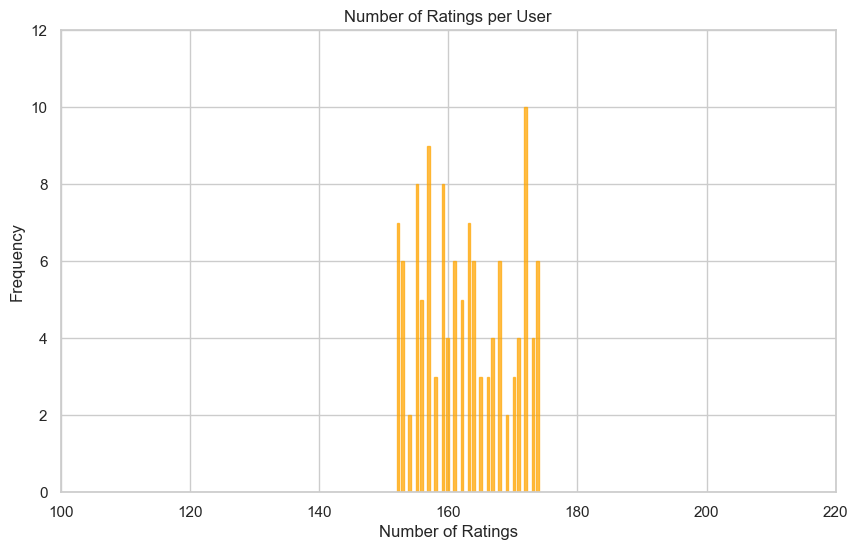

In [49]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(user_ratings_count, bins=60, color='orange', edgecolor='orange', alpha=0.7)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.yticks(range(0, 13, 2))  # Set y-axis ticks from 0 to 12 with interval of 2
plt.xticks(range(100, 221, 20))  # Set x-axis ticks from 0 to 200 with interval of 20
plt.show()

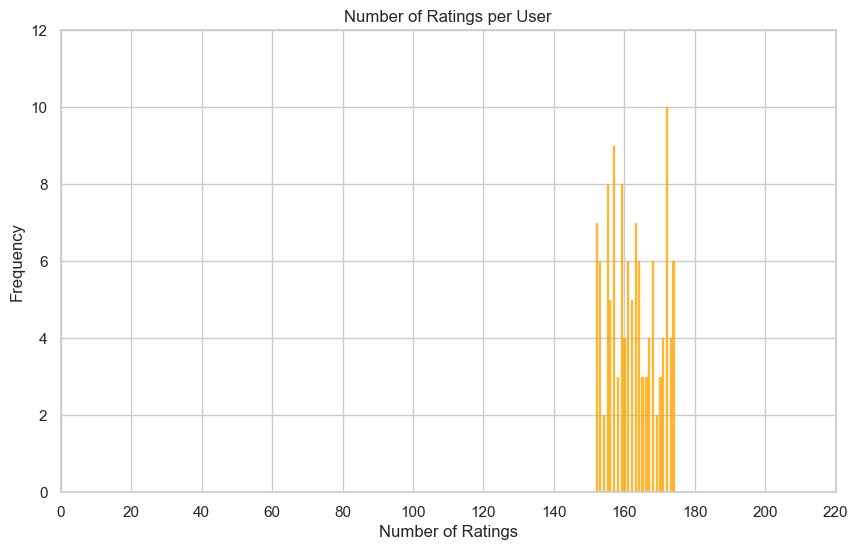

In [42]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(user_ratings_count, bins=60, color='orange', edgecolor='orange', alpha=0.7)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.yticks(range(0, 13, 2))  # Set y-axis ticks from 0 to 12 with interval of 2
plt.xticks(range(0, 221, 20))  # Set x-axis ticks from 0 to 200 with interval of 20
plt.show()

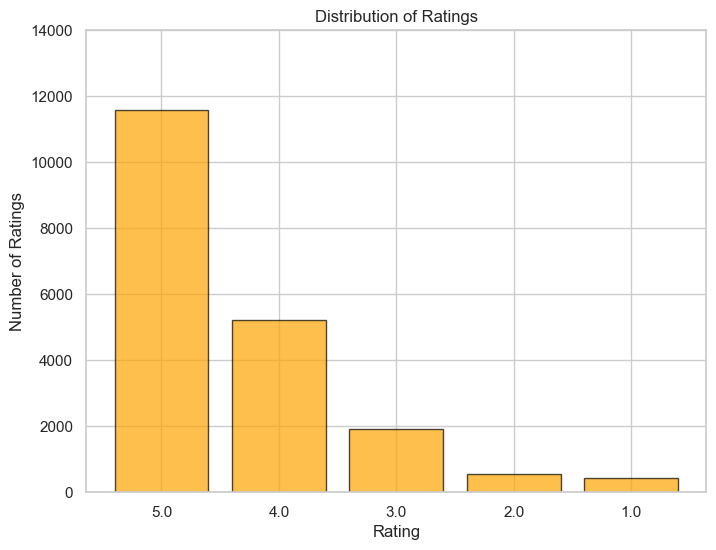

In [48]:
# Plotting the bar chart for distribution of overall ratings
plt.figure(figsize=(8, 6))
plt.bar(rating_counts.index, rating_counts.values, color='orange', edgecolor='black', alpha=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.xticks(rating_counts.index)
#plt.yticks(range(0, max(rating_counts) + 1, 5000))
plt.yticks(range(0, 15000, 2000))  # Set y-axis ticks from 0 to 12 with interval of 2


plt.show()

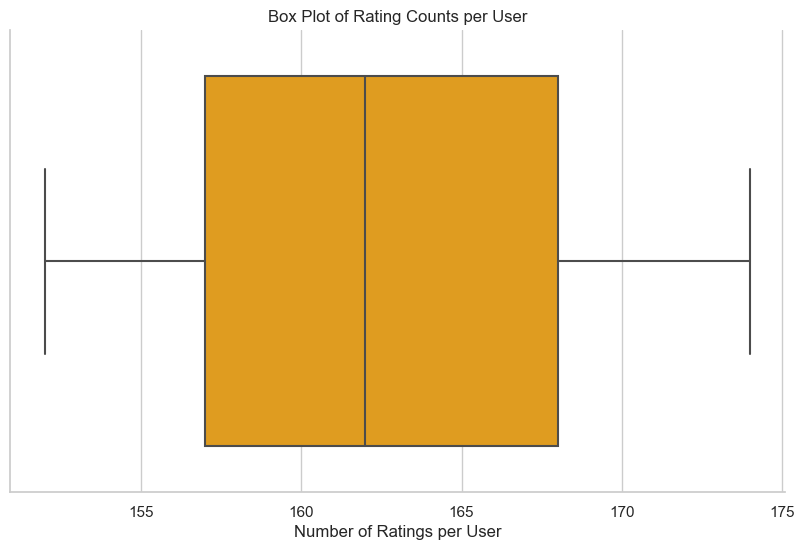

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a box plot of rating counts per user
sns.boxplot(x=user_ratings_count.values, color='orange', ax=ax)

# Set x-axis scale to logarithmic
#ax.set_xscale('log')

# Add titles and labels
plt.title('Box Plot of Rating Counts per User')
plt.xlabel('Number of Ratings per User')

# Remove top and right spines
sns.despine()

# Show plot
plt.show()
